# QOSF Mentorship Application - Task 2
## Karan Khendry - October 2021 Cohort

## Abstract

This notebook presents solutions and extensions to Task 2 of the October 2021 QOSF (Quantum Open Source Foundation) Mentorship Application.

Task 2 Description: Train a variational quantum circuit to transform 4 random 4-qubit input states to the following target states:

|0011>
|0101>
|1010>
|1100>

The solutions presented below make use of the Qiskit open-source SDK and draws inspiration from [1] ["A generative modeling approach for benchmarking and training shallow quantum circuits"](https://www.nature.com/articles/s41534-019-0157-8.pdf). 

Section 1 builds up the overall problem structure and present a solution which uses a simplified version of the data driven approach taken in [1]. In section the problem structure, cost functions, gradient functions and optimizers are built without the use of any ML (Machine Learning) libraries such as Tensorflow or Pytorch. The optimizer and gradient fucntions have in built flexibility to allow for investigation of the best solution through hyperparameter tuning and gradient evaluation. The executed cells below present a finite different gradient descent approach using a TwoLocal ansatz made up of RX, RY and CX gates. The results of section 1 demonstrate a solution that performs the task fairly well but can certainly be improved through further investigation into the ansatz, gradient function and optimizer.

Section 2 uses the basic problem structure from section 1 and attempts to implement some of Qiskit's more sophistaicated in-built gradient functions and optimizers. The results were not as successful as those in Section 1 and the running times experienced were significantly longer.

Details of the approach and results are discussed below.

## Section 1

### Basic Problem Structure and Solution

Let's start by importing the required libraries to solve the task. This notebook's solution of Task 2 relies on Qiskit for the quantum computation and does not utilize any external libraries such as PyTorch or TensorFlow for the classical optimization.

In [24]:
import qiskit
from qiskit import*
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import TwoLocal
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

The following functions are defined to prepare the input and target states. They are designed to be general enough to generate n arbitrary n-qubit input and target states which will be explored after solving Task 2.

In [25]:
def randomStatevectors(n_inputs, n_qubits):
    statevectors = []
    for i in range(n_inputs):
        statevector = np.random.rand(2**n_qubits) + np.random.rand(2**n_qubits)*1j
        statevector = statevector / np.linalg.norm(statevector)
        statevectors.append(statevector)
    return statevectors

def initCircuits(statevectors, n_qubits):
    initial_statevectors = []
    initial_circuits = []
    initial_counts = []
    for statevector in statevectors:
        initial_statevectors.append(statevector)
        initial_circuit = QuantumCircuit(n_qubits)
        initial_circuit.initialize(statevector)
        initial_circuits.append(initial_circuit)
        
        circuit = initial_circuit.copy()
        qasm_simulator = Aer.get_backend('qasm_simulator')
        circuit.measure_all()
        qasm_result = execute(circuit, backend=qasm_simulator).result()
        initial_count = qasm_result.get_counts()
        initial_counts.append(initial_count)
        
    return initial_statevectors, initial_circuits, initial_counts
        
def targetCircuit(target):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    qasm_simulator = Aer.get_backend('qasm_simulator')
    
    target_circuit = QuantumCircuit(len(target))
    for i in reversed(range(len(target))):
        if target[i] == 1:
            target_circuit.x(i)
            
    statevector_result = execute(target_circuit, backend=statevector_simulator).result()
    target_statevector = statevector_result.get_statevector()
    circuit = target_circuit.copy()
    circuit.measure_all()
    qasm_result = execute(circuit, backend=qasm_simulator).result()
    target_count = qasm_result.get_counts()
    return target_statevector, target_circuit, target_count

def targetCircuits(targets):
    target_circuits = []
    target_statevectors = []
    target_counts = []
    for target in targets:
        target_statevector, target_circuit, target_count = targetCircuit(target)
        target_circuits.append(target_circuit)
        target_statevectors.append(target_statevector)
        target_counts.append(target_count)
    return target_statevectors, target_circuits, target_counts

Let's use these functions to set up Task 2. We will initially fix a random seed for reproducbility and proceed to create 4 random 4 qubit quantum states along with the target states defined above. The task is the create a create and train a quantum circuit which can transform our initial random states to the target states. Refer to the histogram below to visualize the probablity distribution of the initial and target states.

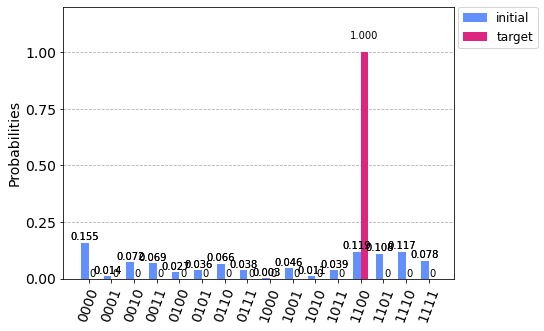

In [26]:
np.random.seed(161803)
qasm_simulator = Aer.get_backend('qasm_simulator')
n_qubits = 4
n_inputs = 4

random_statevectors = randomStatevectors(n_inputs, n_qubits)
initial_statevectors, initial_circuits, initial_counts = initCircuits(random_statevectors, n_qubits)
targets = [[0,0,1,1], [0,1,0,1], [1,0,1,0], [1,1,0,0]] #consider tabulating probz of all 16
# targets = ['1100', '1010', '0101', '0011'] #consider tabulating probz of all 16
target_statevectors, target_circuits, target_counts = targetCircuits(targets)
plot_histogram([initial_counts[3],target_counts[0]], legend=['initial', 'target'])

To create a variational circuit to solve task 2 we must do the following:
1. Generate a parameterized quantum circuit (ansatz) to transform input states to outut states.
2. Develop a cost function to compare the output states to the target states.
3. Optimize the ansatz parameters to minimize the cost function.

For step 1 we will need to initialize an ansatz, define a function to assign parameters to the ansatz and then generate an output circuit which is a composition of the encoded input state and the ansatz. The output distribution of this circuit will be estimated using Qiskit's QASM simulator which will be used to evalue the cost function as discussed later in this notebook. The following cell also includes a few possible ansatz which can be used to solve task 2.

In [27]:
reps = 10
# ansatz = RealAmplitudes(num_qubits=n_qubits, entanglement='full', reps=reps)
ansatz = TwoLocal(n_qubits, ['rx', 'ry'], 'cx', 'full', reps=reps, insert_barriers=True)
#     ansatz = TwoLocal(n_qubits, 'ry', 'cx', 'linear', reps=reps, insert_barriers=True)

def paramCircuit(ansatz, parameters):
    n_parameters = len(parameters)
    for i in range(n_parameters):
        ansatz.assign_parameters({ansatz.parameters[0]: parameters[i]}, inplace=True)
    return ansatz

def executeCircuits(initial_circuits, param_circuit):
    output_statevectors = []
    output_circuits = []
    for i in range(len(initial_circuits)):
        output_circuit = initial_circuits[i].compose(param_circuit.copy())
        output_circuits.append(output_circuit)
    return output_circuits

Let's use the functions above to initialize an ansatz with random parameters and generate and visualize the initial output circuits.

In [28]:
# ansatz = RealAmplitudes(num_qubits=n_qubits, entanglement='full', reps=reps)
ansatz = TwoLocal(n_qubits, ['rx', 'ry'], 'cx', 'full', reps=reps, insert_barriers=True)
# ansatz = TwoLocal(n_qubits, 'ry', 'cx', 'linear', reps=reps, insert_barriers=True)

parameters = np.random.normal(0, np.pi, len(ansatz.parameters))

param_circuit = paramCircuit(ansatz, parameters)
output_circuits = executeCircuits(initial_circuits, param_circuit)

Moving on to step 2; developing a cost function. The following functions are defined to generate a cost function inpsired from the paper ["A generative modeling approach for benchmarking and training shallow quantum circuits"](https://www.nature.com/articles/s41534-019-0157-8.pdf) which takes the approach of minimizing the Kulback-Leibler (KL) Divergence, $D_{KL}[P_\mathcal{D}|P_\theta]$, of the target distribution $P_\mathcal{D}$ and the output distribution of the parameterized circuit $P_\theta$. The paper equates this to estimating the following negative log-likelihood function: 
$$\mathcal{C}(\theta) = -\frac{1}{D}\sum^D_{d=1}{ln(max(\epsilon,P_\theta(x^{(d)})))}$$ where $P_\theta(x^{(d)})$ is the probability of target state $x^(d)$ generated by the circuit paramterized by $\theta$.

$P_\theta(x^{(d)})$ can be estimated using a data driven approach by calculating the likelihood of observing the expected target distribution ($P_\mathcal{D}$) given the data generated from the circuit parameterize by $\theta$ ($P_\theta$).

For this task we will utilize Qiskit's QASM simulator to calculate a simplified version of this likelihood estimation as the number of target state counts generated from the parameterized circuit over the number of counts from the target states generated by the target circuits.

In [29]:
def distDiff(circuit, target, shots=1024):
    target_key = "".join([str(t) for t in target[::-1]])
    dist_circuit = circuit.copy()
    dist_circuit.measure_all()
    result = execute(dist_circuit, backend=qasm_simulator, shots=shots, seed_simulator = 3142, seed_transpiler = 3142).result().get_counts()
    dist_diff = 0
    for key in result.keys():
         if target_key == key:
            dist_diff = result[key]/shots   
    return dist_diff

Let's see what kind of difference value this function yields for the various input and target circuits. Alter the circuit indices below to estimate the difference values.

In [30]:
dist_diff = distDiff(initial_circuits[0], targets[0], shots=256)
print(dist_diff)

0.08203125


Now let's use this data driven difference likelihood estimation of $P_\theta(x^{(d)})$ to generate our negative log-likelihood cost function: $$\mathcal{C}(\theta) = -\frac{1}{D}\sum^D_{d=1}{ln(max(\epsilon,P_\theta(x^{(d)})))}$$

In [31]:
def costFunction(parameters):
#     ansatz = RealAmplitudes(num_qubits=n_qubits, entanglement='full', reps=reps)
    ansatz = TwoLocal(n_qubits, ['rx', 'ry'], 'cx', 'full', reps=reps, insert_barriers=True)
#     ansatz = TwoLocal(n_qubits, 'ry', 'cx', 'linear', reps=reps, insert_barriers=True)

    param_circuit = paramCircuit(ansatz, parameters)
    output_circuits = executeCircuits(initial_circuits, ansatz)
    cost = 0
    eps = 0.01
    for i, circuit in enumerate(output_circuits):
        dist_diff = distDiff(circuit, targets[i], shots=256)
        cost -= np.log(max(eps,dist_diff))
    cost = cost/len(output_circuits)
    return cost

Let's see the cost function in action and take a look at the cost of the input circuits against the target circuits.

In [32]:
cost = costFunction(parameters)
print(cost)

3.9645110011112474


Now we are ready for step 3; optimization to minimize the cost function. The following functions define a finite difference gradient descent optimizer which perturbs each circuit parameter by a decaying $\delta$ shift with probability $\epsilon$ to control the exploration of the cost function space. Each iteration of the optimizer is essentially performing the following:

$$\theta_{i+1} = \theta_i - \alpha\frac{\mathcal{f}(\theta_{i+\delta}) - \mathcal{f}(\theta_{i-\delta})}{(2\delta)}, r < \epsilon$$, where $\alpha$ is the learning rate, 

$\mathcal{f}(\theta)$ is the cost function, 

$\delta$ is the parameter shift, 

$r$ is a random value and 

$\epsilon$ is the probability of perturbing paramter $\theta_i$.

In [33]:
def gradientFunction(parameters, eps, d, lr):
    finite_diffs = np.zeros(len(parameters))
    for i in range(len(parameters)):
        if np.random.rand(1)[0] < eps:
            plus = parameters.copy()
            minus = parameters.copy()
            plus[i] += d
            minus[i] -= d
            cost_plus = costFunction(plus)
            cost_minus = costFunction(minus)
            finite_diffs[i] = lr*(cost_plus - cost_minus)/(2*eps)
    new_params = parameters - finite_diffs       
    return new_params

def optimizer(parameters, lr=0.1, eps = 0.2, d=np.pi/4, max_iter=500):
    best_cost = 10
    loss = []
    convergence_d = [10, 10, 10, 10, 10, 10]
    for i in range(max_iter):
        d = 0.992*d
        parameters = gradientFunction(parameters, eps, d, lr)
        cost = costFunction(parameters)
        print("Iteration " + str(i) + ": Cost = " + str(cost))
        loss.append(cost)
        if cost < best_cost:
            best_parameters = parameters
            best_cost = cost

        convergence_d.append(cost)
        convergence_d.pop(0)

        if np.std(convergence_d) < 0.001: #more sophisticated convergence crtieria to allows for small costs of sophisticated cost function
            break
        
    return loss, best_cost, best_parameters

And finally let's put it all together and evaluate the performance. The loss convergence plot and histogram below show that the input circuits have been trained to have a significantly higher proabability of generating the target states. Try changing the index of the histogram list below to see how the other input states performed.

In [34]:
# ansatz = RealAmplitudes(num_qubits=n_qubits, entanglement='full', reps=reps)
ansatz = TwoLocal(n_qubits, ['rx', 'ry'], 'cx', 'full', reps=reps, insert_barriers=True)
# ansatz = TwoLocal(n_qubits, 'ry', 'cx', 'linear', reps=reps, insert_barriers=True)

parameters = np.random.normal(0, np.pi, len(ansatz.parameters))

loss, best_cost, best_parameters = optimizer(parameters, lr=0.1, eps=0.1, d=np.pi/2, max_iter=200)

Iteration 0: Cost = 3.0365484907439293
Iteration 1: Cost = 2.6969123787021827
Iteration 2: Cost = 2.5544703388523224
Iteration 3: Cost = 2.4484979949937666
Iteration 4: Cost = 2.0846731609586495
Iteration 5: Cost = 1.81771300345831
Iteration 6: Cost = 1.57240678876314
Iteration 7: Cost = 1.5912712542212875
Iteration 8: Cost = 1.4311231877292394
Iteration 9: Cost = 1.3230777310684712
Iteration 10: Cost = 1.3397326621612746
Iteration 11: Cost = 1.2980454502652963
Iteration 12: Cost = 1.2560587435622113
Iteration 13: Cost = 1.153263857783331
Iteration 14: Cost = 1.0948807149951874
Iteration 15: Cost = 1.0625059339456238
Iteration 16: Cost = 1.0136566206521018
Iteration 17: Cost = 0.9974713288308664
Iteration 18: Cost = 0.9898953887045854
Iteration 19: Cost = 0.9113425584135455
Iteration 20: Cost = 0.921593919855201
Iteration 21: Cost = 0.8927127590938608
Iteration 22: Cost = 0.890781544475976
Iteration 23: Cost = 0.8678088948320349
Iteration 24: Cost = 0.8492405961417857
Iteration 25: Cos

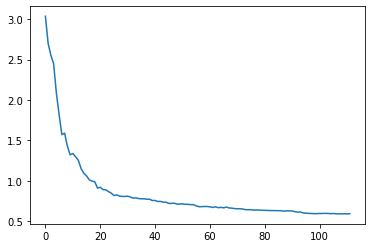

In [35]:
plt.plot(loss)

In [36]:
# ansatz = RealAmplitudes(num_qubits=n_qubits, entanglement='full', reps=reps)
ansatz = TwoLocal(n_qubits, ['rx', 'ry'], 'cx', 'full', reps=reps, insert_barriers=True)
# ansatz = TwoLocal(n_qubits, 'ry', 'cx', 'linear', reps=reps, insert_barriers=True)

histograms = []
param_circuit = paramCircuit(ansatz, best_parameters)
circuits = executeCircuits(initial_circuits, param_circuit)

targets = [[0,0,1,1], [0,1,0,1], [1,0,1,0], [1,1,0,0]]
target_statevectors, target_circuits, target_counts = targetCircuits(targets)

for i, circuit in enumerate(circuits):
    circuit.measure_all()
    shots = 1024
    qasm_simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend=qasm_simulator, shots=shots, seed_simulator = 3142, seed_transpiler = 3142).result().get_counts()
    histograms.append(plot_histogram([result, target_counts[i]]))

In [37]:
targets = [[0,0,1,1], [0,1,0,1], [1,0,1,0], [1,1,0,0]]
target_statevectors, target_circuits, target_counts = targetCircuits(targets)

for i, circuit in enumerate(circuits):
    circuit.measure_all()
    shots = 1024
    qasm_simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend=qasm_simulator, shots=shots, seed_simulator = 3142, seed_transpiler = 3142).result().get_counts()
    histograms.append(plot_histogram([result, target_counts[i]]))

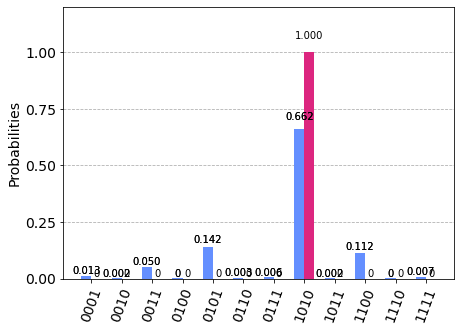

In [44]:
histograms[1]

That's not too bad. We were able to train a Two Local Ansatz with 10 repetitions to output the target states of the problem 50-60% of the time using the finite difference gradient descent optimizer above.

Now with this basic structure let's utilize some of Qiskit's in-built operator, gradient and machine learning tools to see if we can improve performance with more sophisticated techniques. 

## Section 2

### Encoding the Cost Function in Hamiltonian Operators and Utilizing Qiskit's Gradient and Optimization Functions

Firstly, instead of runnning a QASM simulator and computing our simplified cost function, we will encode the our circuit's expecation values into Hamiltonian Observable operators of interest. Since our target states are expressed in the $Z \otimes Z \otimes Z \otimes Z$ basis, we will define functions to utilize this Hamiltonian Observable to express our expected values in the basis of interest. We also need to import the relevent Qiskit libraries.

In [45]:
from qiskit.circuit.library import RealAmplitudes
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import Z, I
from qiskit.opflow import StateFn
from qiskit.opflow import CircuitStateFn
from qiskit.opflow import Gradient, NaturalGradient
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.algorithms.optimizers import SPSA
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit.algorithms.optimizers.gradient_descent import GradientDescent
from qiskit.algorithms.optimizers import SPSA

hamiltonian = Z ^ Z ^ Z ^ Z

Now we re-frame the cost function in terms of the expectation values captured by the Hamiltonian observable. 

As discussed above, the first step is the evaluate, $P_\theta(x^{(d)})$, the probability that target state $x^{(d)}$ is generated by the circuit paramterized by $\theta$. For this approach, we will express $P_\theta(x^{(d)})$ term as the difference between the expectation of the output circuits and the target circuits. We then calculate the cost function $\mathcal{C}(\theta) = -\frac{1}{D}\sum^D_{d=1}{P_\theta(x^{(d)})}$.

In [73]:
def h_costFunction(parameters):
    costs = 0
    for i in range(len(initial_circuits)):
        output_circuit = initial_circuits[i].compose(ansatz)
        target_circuit = target_circuits[i]
        output_expectation = StateFn(hamiltonian, is_measurement=True)@StateFn(output_circuit)
        target_expectation = StateFn(hamiltonian, is_measurement=True)@StateFn(target_circuit)
        cost_op = target_expectation - output_expectation
#         pauli_cost = PauliExpectation().convert(cost_op)
        value_dict = dict(zip(ansatz.parameters, parameters))
        cost = sampler.convert(cost_op, params=value_dict).eval() 
        costs += cost
    return np.abs(costs)

Using the new cost function we can calculate the gradients of the cost function with respect to the circuit parameters to feed into a gradient descent optimizer.

In [88]:
def h_gradientFunction(parameters):
    param_grads = []
    value_dict = dict(zip(ansatz.parameters, parameters))
    for i in range(len(initial_circuits)):
        output_circuit = initial_circuits[i].compose(ansatz)
        target_circuit = target_circuits[i]
        output_expectation = StateFn(hamiltonian, is_measurement=True)@StateFn(output_circuit)
        target_expectation = StateFn(hamiltonian, is_measurement=True)@StateFn(target_circuit)
        cost_op = target_expectation - output_expectation
        grad = Gradient(grad_method="param_shift").convert(cost_op)
#         grad = NaturalGradient(grad_method='param_shift', qfi_method='lin_comb_full', regularization=None).convert(cost_op)
#         grad = sampler.convert(grad, params=value_dict).eval()
        param_grad = np.abs(grad.assign_parameters(value_dict).eval())
        param_grads.append(param_grad)
    mean_param_grads = np.mean(param_grads)
#     new_parameters = list(value_dict.values()) + 0.01*mean_param_grads
#     return new_parameters
    return mean_param_grads

Now we are ready to solve the problem. Let's re-initialize the problem and set up a gradient descent and SPSA optimizer and review the results.

In [89]:
np.random.seed(161803)
n_qubits = 4
n_inputs = 4

reps=1
ansatz = RealAmplitudes(num_qubits=n_qubits, entanglement='full', reps=reps)
# ansatz = TwoLocal(n_qubits, ['rx', 'ry'], 'cx', 'full', reps=reps, insert_barriers=True)
# ansatz = TwoLocal(n_qubits, 'ry', 'cx', 'linear', reps=reps, insert_barriers=True)

random_statevectors = randomStatevectors(n_inputs, n_qubits)
initial_statevectors, initial_circuits, initial_counts = initCircuits(random_statevectors, n_qubits)
targets = [[0,0,1,1], [0,1,0,1], [1,0,1,0], [1,1,0,0]]
target_statevectors, target_circuits, target_counts = targetCircuits(targets)

q_instance = QuantumInstance(backend=qasm_simulator, shots = 256, seed_simulator = 2718, seed_transpiler = 2718)
sampler = CircuitSampler(q_instance)

parameters = np.random.normal(0, np.pi, len(ansatz.parameters))

In [ ]:
from qiskit.algorithms.optimizers.gradient_descent import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    print("Iteration " + str(nfevs) + ": Cost = " + str(fx))
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_callback)

best_parameters, best_cost, nfevs = gd.optimize(parameters.size, h_costFunction, gradient_function=h_gradientFunction, initial_point=parameters)

In [76]:
from qiskit.algorithms.optimizers import SPSA

spsa_loss = []
def spsa_callback(nfevs, x, fx, stepsize, accepted):
    spsa_loss.append(fx)
    print("Iteration " + str(nfevs) + ": Cost = " + str(fx))
    
spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation = 0.1, callback=spsa_callback)

x_opt, fx, nfevs = spsa.optimize(parameters.size, h_costFunction, initial_point=parameters)

Iteration 3: Cost = 4.4609375
Iteration 6: Cost = 4.3203125
Iteration 9: Cost = 4.3203125
Iteration 12: Cost = 4.3046875
Iteration 15: Cost = 3.953125
Iteration 18: Cost = 3.875
Iteration 21: Cost = 3.7578125
Iteration 24: Cost = 3.34375
Iteration 27: Cost = 3.3125
Iteration 30: Cost = 3.2734375
Iteration 33: Cost = 3.25
Iteration 36: Cost = 2.8515625
Iteration 39: Cost = 2.875
Iteration 42: Cost = 2.828125
Iteration 45: Cost = 2.828125
Iteration 48: Cost = 2.71875
Iteration 51: Cost = 2.703125
Iteration 54: Cost = 2.71875
Iteration 57: Cost = 2.6796875
Iteration 60: Cost = 2.625
Iteration 63: Cost = 2.5859375
Iteration 66: Cost = 2.578125
Iteration 69: Cost = 2.453125
Iteration 72: Cost = 2.3359375
Iteration 75: Cost = 2.28125
Iteration 78: Cost = 2.2890625
Iteration 81: Cost = 2.2578125
Iteration 84: Cost = 1.9921875
Iteration 87: Cost = 1.9609375
Iteration 90: Cost = 1.9140625
Iteration 93: Cost = 1.9296875
Iteration 96: Cost = 1.9296875
Iteration 99: Cost = 1.921875
Iteration 102: 

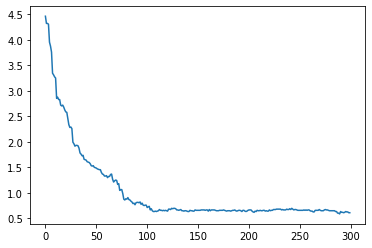

In [77]:
plt.plot(spsa_loss)
# plt.plot(gd_loss)

In [78]:
ansatz = RealAmplitudes(num_qubits=n_qubits, entanglement='full', reps=reps)
# ansatz = TwoLocal(n_qubits, ['rx', 'ry'], 'cx', 'full', reps=reps, insert_barriers=True)
# ansatz = TwoLocal(n_qubits, 'ry', 'cx', 'linear', reps=reps, insert_barriers=True)
histograms = []
param_circuit = paramCircuit(ansatz, x_opt)
circuits = executeCircuits(initial_circuits, param_circuit)

targets = [[0,0,1,1], [0,1,0,1], [1,0,1,0], [1,1,0,0]]
target_statevectors, target_circuits, target_counts = targetCircuits(targets)

for i, circuit in enumerate(circuits):
    circuit.measure_all()
    shots = 1024
    qasm_simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend=qasm_simulator, shots=shots, seed_simulator = 3142, seed_transpiler = 3142).result().get_counts()
    histograms.append(plot_histogram([result, target_counts[i]]))

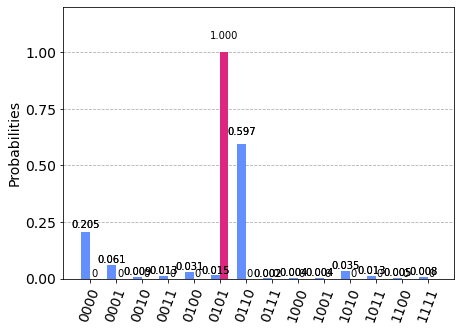

In [84]:
histograms[2]

It is interesting to see that the circuit is converging to output state $\ket{0110}$ regardless of the input state instead of converging to the target states. Improvements to this approach can be made in future work.

## Conclusion

Section 1 showed a moderately successful solution to Task 2 using the simplified data driven approach. It is unclear whether to solution presented above reached a global minimum in the circuits parameter space but from the various trials, approaches and hyper parameter tuning that was experimented with the attempted ansatz, it does appear the global minimum of the ansatz were reached. Therefore, to improve performance in Section 1, different ansatz with more gates, repititions and entangling may be required in order to broaden the space and find more optimal parameters. Moreover, further work can be done to implement alternate optimizers such as simulated annealing or stochastic gradient descent to try to improve running time and convergence.

Section 2 was not able to successfully solve the task and may require more fine tuning and debugging of the code. I believe the flaw stems from the non-standard cost function which was attempted. While most variational circuits minimize the hamiltonian observable of a particular circuit, this project attempted to take the difference between the hamiltonian observables of the output and target circuits to represent the cost function. The mathematics of how to operators commute will be investigated further to understand if this is a valid approach. Additionally, further work can be done to explore Qiskit's various gradient and optimizer features such as Quantum Natural Gradients.